<a href="https://colab.research.google.com/github/cicerohen/hands-on-ml-book/blob/main/hands_on_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Setup & Data Acquisition**
In this section, we prepare the laboratory and gather the raw materials.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from IPython.display import HTML

# Load Data
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)

# Train/Test Split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **2. Binary Classification (The "5-Detector")**

We start simple: can the model distinguish a '5' from everything else?

In [ ]:
# Create binary labels
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Train SGD
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Performance Evaluation
# Note: Accuracy is misleading here because only 10% of images are 5s.
cv_accuracy = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"CV Accuracy: {cv_accuracy}")

CV Accuracy: [0.95035 0.96035 0.9604 ]


### **3. Metrics & The Precision/Recall Tradeoff**

Going beyond accuracy to understand False Positives and False Negatives.

In [ ]:
# Confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
conf_matrix_df = pd.DataFrame(cm,index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
html_table = conf_matrix_df.to_html(classes='table table-bordered')
HTML(html_table)

,Predicted Negative,Predicted Positive
Actual Negative,53892,687
Actual Positive,1891,3530


Precision: 0.8370879772350012
Recall: 0.6511713705958311


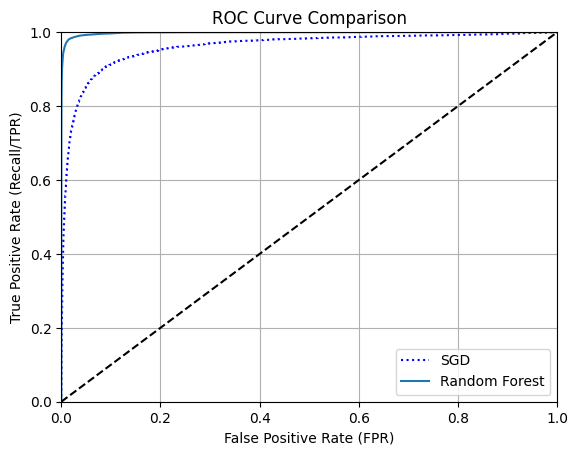

SGD ROC AUC Score: 0.9604938554008616
Random Forest ROC AUC Score: 0.9983436731328145


In [ ]:
# Basic Metrics

print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")

# Get scores for SGD (using decision_function)
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_5, y_scores_sgd)

# Get scores for Random Forest (using probabilities)
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # Score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


# Plot the comparison
plt.plot(fpr_sgd, tpr_sgd, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line (random guess)
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall/TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.title("ROC Curve Comparison")
plt.show()


# Calculate the Area Under the Curve (AUC)
print(f"SGD ROC AUC Score: {roc_auc_score(y_train_5, y_scores_sgd)}")
print(f"Random Forest ROC AUC Score: {roc_auc_score(y_train_5, y_scores_forest)}")

### **4. Multiclass Classification (0-9)**

Now we challenge the model to identify all ten digits using One-vs-All (OvA).

In [ ]:
# Training the full model
sgd_clf.fit(X_train, y_train)

# Testing a specific digit (The '5' that often looks like a '3')
some_digit = X[0] # This is a 5
prediction = sgd_clf.predict([some_digit])
scores = sgd_clf.decision_function([some_digit])

print(f"Prediction: {prediction}")
print(f"Decision Scores: {scores}")

Prediction: [3]
Decision Scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


### **5. Feature Scaling & Performance Boost**

Transforming the data to provide a "Level Playing Field" for the SGD algorithm.

In [ ]:
# Applying StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Verifying Improvement
scaled_cv_accuracy = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"Scaled CV Accuracy: {scaled_cv_accuracy}")

Scaled CV Accuracy: [0.8983 0.891  0.9018]


### **6. Error Analysis**

Investigating the "Why" behind the mistakes.

In [ ]:
# Confusion matrix
y_train_pred_scaled = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred_scaled)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
# Plotting the Confusion Matrix Table

digit_labels = [str(i) for i in range(10)]
conf_matrix_df = pd.DataFrame(conf_mx,
                              index=[f"Actual {i}" for i in digit_labels],
                              columns=[f"Predicted {i}" for i in digit_labels])
html_table = conf_matrix_df.to_html(classes='table table-bordered')
HTML(html_table)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,5577,0,22,5,8,43,36,6,225,1
Actual 1,0,6400,37,24,4,44,4,7,212,10
Actual 2,27,27,5220,92,73,27,67,36,378,11
Actual 3,22,17,117,5227,2,203,27,40,403,73
Actual 4,12,14,41,9,5182,12,34,27,347,164
Actual 5,27,15,30,168,53,4444,75,14,535,60
Actual 6,30,15,42,3,44,97,5552,3,131,1
Actual 7,21,10,51,30,49,12,3,5684,195,210
Actual 8,17,63,48,86,3,126,25,10,5429,44
Actual 9,25,18,30,64,118,36,1,179,371,5107


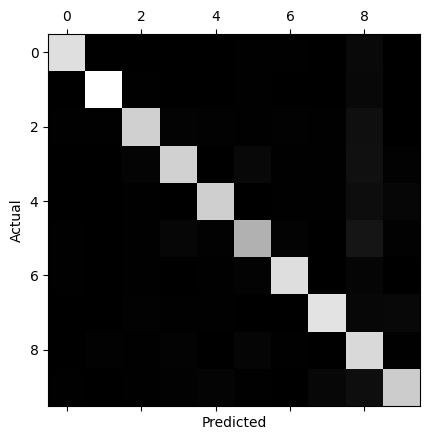

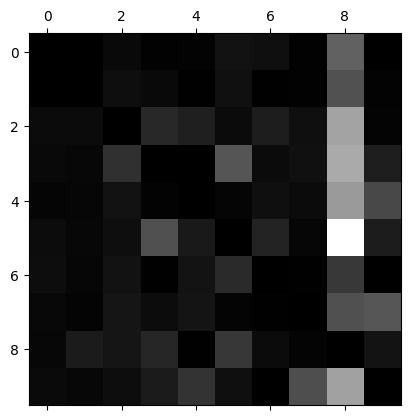

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Focus on errors: Divide each value by the number of images in the class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0) # Fill diagonal with 0 to highlight only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### **7. Multilabel Classification**

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,
cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

### **8. Multioutput classification**

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

[[82 53 92 ... 35 94 98]
 [94  0 56 ... 73 95 24]
 [85 75 32 ... 59 32 52]
 ...
 [88 46 65 ... 48 16 43]
 [69 96 83 ...  8 41 45]
 [ 3 53 98 ... 65 42 30]]


In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])


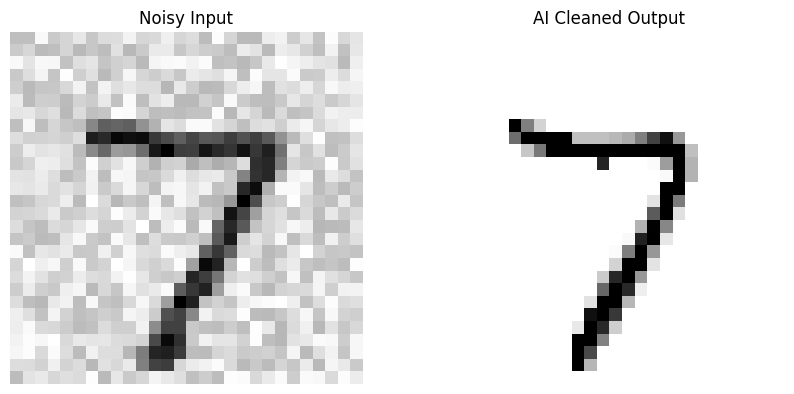

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 2. Create a side-by-side comparison
plt.figure(figsize=(10, 5))

# Plot the noisy version (The Input)
plt.subplot(1, 2, 1)
plot_digit(X_test_mod[0])
plt.title("Noisy Input")

# Plot the clean_digit (The AI's Prediction)
plt.subplot(1, 2, 2)
plot_digit(clean_digit)
plt.title("AI Cleaned Output")

plt.show()